**Корректность проверена на Python 3.6:**
+ pandas 0.23.4
+ numpy 1.15.4
+ matplotlib 3.0.2
+ sklearn 0.20.2

# Метод главных компонент

В данном задании вам будет предложено ознакомиться с подходом, который переоткрывался в самых разных областях, имеет множество разных интерпретаций, а также несколько интересных обобщений: методом главных компонент (principal component analysis).

## Programming assignment

Задание разбито на две части: 
- работа с модельными данными,
- работа с реальными данными.

В конце каждого пункта от вас требуется получить ответ и загрузить в соответствующую форму.

In [1]:
import numpy as np
import pandas as pd
import matplotlib
from matplotlib import pyplot as plt
import matplotlib.patches as mpatches
matplotlib.style.use('ggplot')
%matplotlib inline

## Теория

Любой набор данных представляет собой матрицу $X$.

Метод главных компонент последовательно находит следующие линейные комбинации признаков (компоненты) из $X$:
- каждая компонента ортогональна всем остальным и нормированна: $<w_i, w_j> = 0, \quad ||w_i||=1$,
- каждая компонента описывает максимально возможную дисперсию данных (с учётом предыдущего ограничения).

Предположения, в рамках которых данный подход будет работать хорошо:
- линейность компонент: мы предполагаем, что данные можно анализировать линейными методами,
- большие дисперсии важны: предполагается, что наиболее важны те направления в данных, вдоль которых они имеют наибольшую дисперсию,
- все компоненты ортогональны: это предположение позволяет проводить анализ главных компонент при помощи техник линейной алгебры (например, сингулярное разложение матрицы $X$ или спектральное разложение матрицы $X^TX$).

Как это выглядит математически?

Обозначим следующим образом выборочную матрицу ковариации данных: $\hat{C} \propto Q = X^TX$. ($Q$ отличается от $\hat{C}$ нормировкой на число объектов).

Сингулярное разложение матрицы $Q$ выглядит следующим образом:

$$Q = X^TX = W \Lambda W^T$$

Можно строго показать, что столбцы матрицы $W$ являются главными компонентами матрицы $X$, т.е. комбинациями признаков, удовлетворяющих двум условиям, указанным в начале. При этом дисперсия данных вдоль направления, заданного каждой компонентой, равна соответствующему значению диагональной матрицы $\Lambda$.

Как же на основании этого преобразования производить уменьшение размерности? Мы можем отранжировать компоненты, используя значения дисперсий данных вдоль них.

Сделаем это: $\lambda_{(1)} > \lambda_{(2)} > \dots > \lambda_{(D)}$.

Тогда, если мы выберем компоненты, соответствующие первым $d$ дисперсиям из этого списка, мы получим набор из $d$ новых признаков, которые наилучшим образом описывают дисперсию изначального набора данных среди всех других возможных линейных комбинаций исходных признаков матрицы $X$. 
- Если $d=D$, то мы вообще не теряем никакой информации.
- Если $d<D$, то мы теряем информацию, которая, при справедливости указанных выше предположений, будет пропорциональна сумме дисперсий отброшенных компонент.

Получается, что метод главных компонент позволяет нам ранжировать полученные компоненты по "значимости", а также запустить процесс их отбора.

## Пример

Рассмотрим набор данных, который сэмплирован из многомерного нормального распределения с матрицей ковариации $C = \begin{pmatrix} 3 & 1 \\ 1 & 2 \end{pmatrix}$.

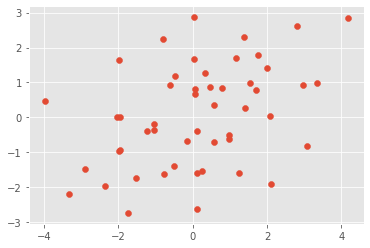

In [2]:
from sklearn.decomposition import PCA

mu = np.zeros(2)
C = np.array([[3,1],[1,2]])

data = np.random.multivariate_normal(mu, C, size=50)
plt.scatter(data[:,0], data[:,1])
plt.show()

Путём диагонализации истинной матрицы ковариаций $C$, мы можем найти преобразование исходного набора данных, компоненты которого наилучшим образом будут описывать дисперсию, с учётом их ортогональности друг другу:

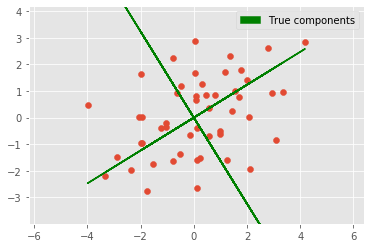

In [3]:
v, W_true = np.linalg.eig(C)

plt.scatter(data[:,0], data[:,1])
# построим истинные компоненты, вдоль которых максимальна дисперсия данных
plt.plot(data[:,0], (W_true[0,0]/W_true[0,1])*data[:,0], color="g")
plt.plot(data[:,0], (W_true[1,0]/W_true[1,1])*data[:,0], color="g")
g_patch = mpatches.Patch(color='g', label='True components')
plt.legend(handles=[g_patch])
plt.axis('equal')
limits = [np.minimum(np.amin(data[:,0]), np.amin(data[:,1])),
          np.maximum(np.amax(data[:,0]), np.amax(data[:,1]))]
plt.xlim(limits[0],limits[1])
plt.ylim(limits[0],limits[1])
plt.draw()

А теперь сравним эти направления с направлениями, которые выбирает метод главных компонент:

In [25]:
def plot_principal_components(data, model, scatter=True, legend=True):
    W_pca = model.components_
    if scatter:
        plt.scatter(data[:,0], data[:,1])
    plt.plot(data[:,0], -(W_pca[0,0]/W_pca[0,1])*data[:,0], color="c")
    plt.plot(data[:,0], -(W_pca[1,0]/W_pca[1,1])*data[:,0], color="c")
    if legend:
        c_patch = mpatches.Patch(color='c', label='Principal components')
        plt.legend(handles=[c_patch], loc='lower right')
    # сделаем графики красивыми:
    plt.axis('equal')
    limits = [np.minimum(np.amin(data[:,0]), np.amin(data[:,1]))-0.5,
              np.maximum(np.amax(data[:,0]), np.amax(data[:,1]))+0.5]
    plt.xlim(limits[0],limits[1])
    plt.ylim(limits[0],limits[1])
    plt.draw()

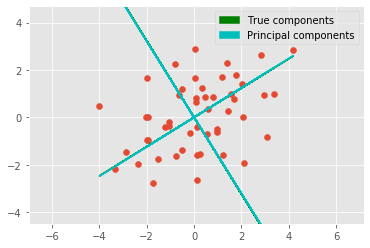

In [26]:
model = PCA(n_components=2)
model.fit(data)

plt.scatter(data[:,0], data[:,1])
# построим истинные компоненты, вдоль которых максимальна дисперсия данных
plt.plot(data[:,0], (W_true[0,0]/W_true[0,1])*data[:,0], color="g")
plt.plot(data[:,0], (W_true[1,0]/W_true[1,1])*data[:,0], color="g")
# построим компоненты, полученные с использованием метода PCA:
plot_principal_components(data, model, scatter=False, legend=False)
c_patch = mpatches.Patch(color='c', label='Principal components')
plt.legend(handles=[g_patch, c_patch])
plt.draw()

Видно, что уже при небольшом количестве данных они отличаются незначительно. Увеличим размер выборки:

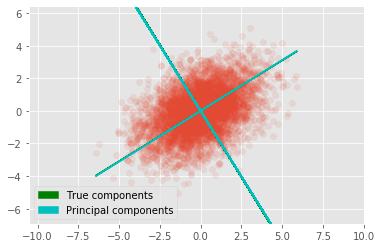

In [27]:
data_large = np.random.multivariate_normal(mu, C, size=5000)

model = PCA(n_components=2)
model.fit(data_large)
plt.scatter(data_large[:,0], data_large[:,1], alpha=0.1)
# построим истинные компоненты, вдоль которых максимальна дисперсия данных
plt.plot(data_large[:,0], (W_true[0,0]/W_true[0,1])*data_large[:,0], color="g")
plt.plot(data_large[:,0], (W_true[1,0]/W_true[1,1])*data_large[:,0], color="g")
# построим компоненты, полученные с использованием метода PCA:
plot_principal_components(data_large, model, scatter=False, legend=False)
c_patch = mpatches.Patch(color='c', label='Principal components')
plt.legend(handles=[g_patch, c_patch])
plt.draw()

В этом случае главные компоненты значительно точнее приближают истинные направления данных, вдоль которых наблюдается наибольшая дисперсия.

## Статистический взгляд на модель

Как формализовать предположения метода, указанные выше? При помощи вероятностной модели!

Задача, стоящая за любым методом уменьшения размерности: получить из набора зашумлённых признаков $X$ истинные значения $Y$, которые на самом деле определяют набор данных (т.е. сведение датасета с большим количеством признаков к данным, имеющим т.н. "эффективную размерность").

В случае метода главных компонент мы хотим найти направления, вдоль которых максимальна дисперсия, с учётом описанных выше предположений о структуре данных и компонент.

Материал, описанный ниже в данной секции, не обязателен для ознакомления для выполнения следующего задания, т.к. требует некоторых знаний статистики.

Для тех, кто собирается его пропустить: в конце раздела мы получим метрику качества, которая должна определять, насколько данные хорошо описываются построенной моделью при заданном числе компонент. Отбор признаков при этом сводится к тому, что мы выбираем то количество компонент, при котором используемая метрика (логарифм правдоподобия) является максимальной.

С учётом предположений задача метода главных компонент выглядит следующим образом:

$$ x = Wy + \mu + \epsilon$$

где:
- $x$ -- наблюдаемые данные
- $W$ -- матрица главных компонент (каждый стобец -- одна компонента)
- $y$ -- их проекция на главные компоненты
- $\mu$ -- среднее наблюдаемых данных
- $\epsilon \sim \mathcal{N}(0, \sigma^2I)$ -- нормальный шум

Исходя из распределения шума, выпишем распределение на $x$:

$$p(x \mid y) = \mathcal{N}(Wx + \mu, \sigma^2I) $$

Введём априорное распределение на $y$:

$$p(y) = \mathcal{N}(0, 1)$$

Выведем из этого при помощи формулы Байеса маргинальное распределение на $p(x)$:

$$p(x) = \mathcal{N}(\mu, \sigma^2I + WW^T)$$

Тогда правдоподобие набора данных при условии используемой модели выглядит следующим образом:

$$\mathcal{L} = \sum_{i=1}^N \log p(x_i) = -N/2 \Big( d\log(2\pi) + \log |C| + \text{tr}(C^{-1}S) \Big)$$

где:
- $C = \sigma^2I + WW^T$ -- матрица ковариации в маргинальной модели
- $S = \frac{1}{N} \sum_{i=1}^N (x_i - \mu)(x_i - \mu)^T$ -- выборочная ковариация

Значение $\mathcal{L}$ имеет смысл логарифма вероятности получения набора данных $X$ при условии, что он удовлетворяет предположениям модели метода главных компонент. Чем оно больше -- тем лучше модель описывает наблюдаемые данные.

## Задание 1. Автоматическое уменьшение размерности данных при помощи логарифма правдоподобия $\mathcal{L}$

Рассмотрим набор данных размерности $D$, чья реальная размерность значительно меньше наблюдаемой (назовём её $d$). От вас требуется:

1. Для каждого значения $\hat{d}$ в интервале [1,D] построить модель PCA с $\hat{d}$ главными компонентами.
2. Оценить средний логарифм правдоподобия данных для каждой модели на генеральной совокупности, используя метод кросс-валидации с 3 фолдами (итоговая оценка значения логарифма правдоподобия усредняется по всем фолдам).
3. Найти модель, для которой он максимален, и внести в форму ответа число компонент в данной модели, т.е. значение $\hat{d}_{opt}$.

Для оценки логарифма правдоподобия модели для заданного числа главных компонент при помощи метода кросс-валидации используйте следующие функции:

    model = PCA(n_components=n)
    scores = cv_score(model, data)
        
Обратите внимание, что scores -- это вектор, длина которого равна числу фолдов. Для получения оценки на правдоподобие модели его значения требуется усреднить.

Для визуализации оценок можете использовать следующую функцию:

    plot_scores(d_scores)
    
которой на вход передаётся вектор полученных оценок логарифма правдоподобия данных для каждого $\hat{d}$.

Для интересующихся: данные для заданий 1 и 2 были сгенерированны в соответствии с предполагаемой PCA моделью. То есть: данные $Y$ с эффективной размерностью $d$, полученные из независимых равномерных распределений, линейно траснформированны случайной матрицей $W$ в пространство размерностью $D$, после чего ко всем признакам был добавлен независимый нормальный шум с дисперсией $\sigma$.

In [28]:
from sklearn.decomposition import PCA
from sklearn.model_selection import cross_val_score as cv_score

def plot_scores(d_scores):
    n_components = np.arange(1,d_scores.size+1)
    plt.plot(n_components, d_scores, 'b', label='PCA scores')
    plt.xlim(n_components[0], n_components[-1])
    plt.xlabel('n components')
    plt.ylabel('cv scores')
    plt.legend(loc='lower right')
    plt.show()
        
data1 = pd.read_csv('data_task1.csv')

In [29]:
data1.head()

,0,1,2,3,4,5,6,7,8,9,...,70,71,72,73,74,75,76,77,78,79
0,-0.238399,-1.311330,-0.782298,-0.341821,0.469353,-0.431860,0.602948,1.220206,1.525103,-0.991354,...,-0.559927,-0.532534,-0.465923,0.874697,-0.108972,-0.080328,0.448971,2.080754,-1.535373,-0.460125
1,-0.223940,-1.277836,-0.202433,-0.317682,0.081900,-0.624267,-0.577119,-0.489564,0.704099,-0.511071,...,-0.055943,-2.208109,0.027813,-1.663044,0.018190,-0.432993,1.204321,0.705121,-1.106140,0.145533
2,-0.278740,1.342790,-0.734591,0.618881,1.365690,-1.397553,-1.446412,-0.844917,0.845916,-1.574979,...,-1.616313,2.144484,-1.110290,-0.524140,-2.176645,-1.903969,1.715735,0.054220,-1.125896,1.309994
3,0.585189,0.344587,1.512917,0.272105,0.480314,-0.688009,-1.473050,-0.732295,0.407361,0.900369,...,1.107443,-0.948995,0.555096,0.645465,1.291971,0.690657,-0.322088,0.341865,-1.436627,0.231027
4,0.992821,-0.654237,2.431634,-1.167275,0.347093,0.772373,0.766213,-0.441367,0.632604,1.543905,...,0.088682,1.357311,0.739249,-0.213874,0.521273,-0.885125,-1.262695,0.974920,1.139357,-0.104045


In [30]:
log_likelyhoods = {}
for d in range(1, len(data1.columns)+1):
    model = PCA(n_components=d, svd_solver='full')
    log_likelyhoods[d] = cv_score(estimator=model, X=data1, cv=3).mean()

In [31]:
log_likelyhoods

{1: -122.3832914032581,
 2: -122.32275875454741,
 3: -122.26760764702244,
 4: -122.21624956968888,
 5: -122.15799429767453,
 6: -122.09637862596331,
 7: -122.02189733698539,
 8: -121.95593776129425,
 9: -121.87749075898465,
 10: -121.77732802165669,
 11: -121.71097811883556,
 12: -121.62329859827707,
 13: -121.55137182732055,
 14: -121.46878314267728,
 15: -121.3834398821217,
 16: -121.29335963367743,
 17: -121.17522478349626,
 18: -121.0640011521462,
 19: -120.93580105089326,
 20: -120.80085035503294,
 21: -120.82598103217565,
 22: -120.84749840011519,
 23: -120.87358498151089,
 24: -120.89093605393687,
 25: -120.91093317359515,
 26: -120.92595193074915,
 27: -120.93423091109518,
 28: -120.95477382532859,
 29: -120.97094247085312,
 30: -120.98927970594967,
 31: -121.00532889463169,
 32: -121.01652610582624,
 33: -121.03016562334979,
 34: -121.03988236316125,
 35: -121.05189121771446,
 36: -121.06061953492072,
 37: -121.06965157860755,
 38: -121.08120610479973,
 39: -121.09684869538351

In [32]:
max(log_likelyhoods, key=log_likelyhoods.get)

20

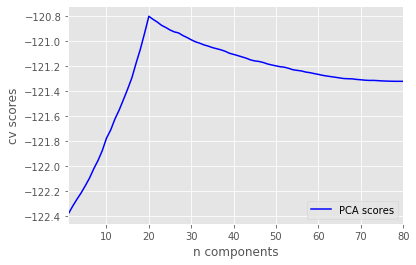

In [33]:
plot_scores(pd.DataFrame(log_likelyhoods.values()))

## Вариационный взгляд на модель

Мы знаем, что каждой главной компоненте соответствует описываемая ей дисперсия данных (дисперсия данных при проекции на эту компоненту). Она численно равна значению диагональных элементов матрицы $\Lambda$, получаемой из спектрального разложения матрицы ковариации данных (смотри теорию выше).

Исходя из этого, мы можем отсортировать дисперсию данных вдоль этих компонент по убыванию, и уменьшить размерность данных, отбросив $q$ итоговых главных компонент, имеющих наименьшую дисперсию.

Делать это можно двумя разными способами. Например, если вы вдальнейшем обучаете на данных с уменьшенной размерностью модель классификации или регрессии, то можно запустить итерационный процесс: удалять компоненты с наименьшей дисперсией по одной, пока качество итоговой модели не станет значительно хуже.

Более общий способ отбора признаков заключается в том, что вы можете посмотреть на разности в дисперсиях в отсортированном ряде $\lambda_{(1)} > \lambda_{(2)} > \dots > \lambda_{(D)}$: $\lambda_{(1)}-\lambda_{(2)}, \dots, \lambda_{(D-1)} - \lambda_{(D)}$, и удалить те компоненты, на которых разность будет наибольшей. Именно этим методом вам и предлагается воспользоваться для тестового набора данных.

## Задание 2. Ручное уменьшение размерности признаков посредством анализа дисперсии данных вдоль главных компонент

Рассмотрим ещё один набор данных размерности $D$, чья реальная размерность значительно меньше наблюдаемой (назовём её также $d$). От вас требуется:

1. Построить модель PCA с $D$ главными компонентами по этим данным.
2. Спроецировать данные на главные компоненты.
3. Оценить их дисперсию вдоль главных компонент.
4. Отсортировать дисперсии в порядке убывания и получить их попарные разности: $\lambda_{(i-1)} - \lambda_{(i)}$.
5. Найти разность с наибольшим значением и получить по ней оценку на эффективную размерность данных $\hat{d}$.
6. Построить график дисперсий и убедиться, что полученная оценка на $\hat{d}_{opt}$ действительно имеет смысл, после этого внести полученное значение $\hat{d}_{opt}$ в форму ответа.

Для построения модели PCA используйте функцию:

    model.fit(data)
    
Для трансформации данных используйте метод:

    model.transform(data)
    
Оценку дисперсий на трансформированных данных от вас потребуется реализовать вручную. Для построения графиков можно воспользоваться функцией

    plot_variances(d_variances)
    
которой следует передать на вход отсортированный по убыванию вектор дисперсий вдоль компонент.

In [34]:
from sklearn.decomposition import PCA
from sklearn.model_selection import cross_val_score as cv_score

def plot_variances(d_variances):
    n_components = np.arange(1,d_variances.size+1)
    plt.plot(n_components, d_variances, 'b', label='Component variances')
    plt.xlim(n_components[0], n_components[-1])
    plt.xlabel('n components')
    plt.ylabel('variance')
    plt.legend(loc='upper right')
    plt.show()
        
data2 = pd.read_csv('data_task2.csv')

In [35]:
data2.head()

,0,1,2,3,4,5,6,7,8,9,...,90,91,92,93,94,95,96,97,98,99
0,0.848776,-0.666596,-0.724109,-0.584370,-0.460105,1.161415,-0.153160,-2.253871,1.375337,0.561841,...,1.328021,0.615259,1.447412,1.177600,-0.643321,0.005454,-1.075457,0.636591,0.075188,-0.461723
1,0.560569,-0.493592,-0.149612,-0.262415,0.967470,-1.094108,0.815526,0.487121,1.537931,-2.168744,...,0.523245,-0.979103,2.280059,-1.413170,1.146576,-1.179831,0.569553,-0.073751,-0.841962,0.474029
2,-1.484923,-0.622672,0.305978,0.040120,-2.851857,0.092543,-0.029286,-0.624243,-1.155940,0.658744,...,0.916887,1.494340,-1.801660,0.164034,0.467053,-0.872597,0.066600,1.388963,-1.446373,-0.002239
3,-1.487085,-0.252582,-0.429568,-0.124176,-0.547003,0.942490,-0.783337,-0.994770,2.140593,-0.978872,...,-1.177229,-0.892356,-0.166295,-1.507428,1.218209,-0.769020,1.439147,0.713580,0.765335,-0.452884
4,0.462349,0.751057,0.140967,-0.006099,-0.244748,-0.075261,0.924772,0.417142,-0.985730,-1.375670,...,-1.392519,0.502969,1.538669,1.002944,-0.832352,0.990356,-1.733266,-0.201313,-0.834691,-1.118169


In [36]:
model2 = PCA(n_components=100)
model2.fit(data2)

PCA(copy=True, iterated_power='auto', n_components=100, random_state=None,
    svd_solver='auto', tol=0.0, whiten=False)

In [37]:
projections2 = model2.transform(data2)

In [38]:
pd.DataFrame(projections2).head()

,0,1,2,3,4,5,6,7,8,9,...,90,91,92,93,94,95,96,97,98,99
0,-0.303448,-1.297513,-0.702393,-2.100699,0.520796,0.388870,-2.732780,-0.848452,1.835597,1.114013,...,-0.368638,-1.697923,-0.128998,1.535820,-1.314162,0.361324,1.201469,-1.477302,1.116291,-0.252445
1,-0.091535,0.650522,-0.652686,0.927167,-1.423604,-0.760707,0.928270,0.447745,-0.945732,0.817630,...,-0.452612,0.473226,-1.808577,-0.506027,1.045131,0.522461,0.255927,0.564312,-0.100945,0.600525
2,-3.993845,0.790416,-1.319794,2.666427,-0.375565,-1.354022,0.435933,0.108115,-1.620338,2.712436,...,-0.106978,0.195364,-1.258126,-0.405298,0.506323,-0.107232,-1.698538,1.019342,1.407971,-0.380809
3,0.479414,-1.830775,-1.315965,-0.850315,1.133751,0.662747,-0.144562,-1.900226,0.791622,-2.571803,...,-0.283668,-0.503954,0.792451,-0.181166,-1.087597,0.544176,-1.177099,-0.270474,-0.364001,1.512906
4,-1.595146,1.903184,1.462989,-1.326389,0.884250,1.486740,0.289936,-1.297772,-1.161080,0.809535,...,-0.776620,-0.182557,-0.007264,-1.808407,0.473013,-0.667921,-0.974934,0.377042,-0.366798,0.395957


In [39]:
model2.explained_variance_

array([2.45300783, 2.34721594, 2.32837423, 2.29215638, 2.26058883,
       2.23673763, 2.23054413, 2.16149946, 2.12419737, 2.11722001,
       2.101506  , 2.08661632, 2.06952524, 2.01874997, 2.01569559,
       1.9975306 , 1.98999226, 1.97267641, 1.96145946, 1.93571547,
       1.91127464, 1.88088269, 1.87313498, 1.86100004, 1.83748995,
       1.83102547, 1.76695482, 1.75990976, 1.70900529, 1.67441869,
       1.30213235, 1.27412642, 1.25988718, 1.24829741, 1.2373551 ,
       1.22655268, 1.2160363 , 1.20337612, 1.19178072, 1.17704893,
       1.17152643, 1.1596937 , 1.14421427, 1.13733863, 1.1280918 ,
       1.12091597, 1.11941323, 1.10887359, 1.10153552, 1.09280867,
       1.08081406, 1.071599  , 1.06894519, 1.05953135, 1.05917675,
       1.03999244, 1.03181196, 1.02157178, 1.01563714, 1.00589789,
       1.00414164, 0.99383921, 0.98822987, 0.9841911 , 0.98022019,
       0.96913754, 0.96047364, 0.95574247, 0.9486803 , 0.94342659,
       0.94097477, 0.93152563, 0.92430892, 0.92160925, 0.91402

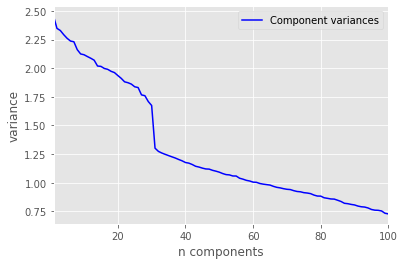

In [40]:
plot_variances(model2.explained_variance_)

In [41]:
var_diff = np.array([model2.explained_variance_[i] - model2.explained_variance_[i+1] for i in range(99)])

In [42]:
np.argmax(var_diff)+1

30

## Интерпретация главных компонент

В качестве главных компонент мы получаем линейные комбинации исходных призанков, поэтому резонно возникает вопрос об их интерпретации.

Для этого существует несколько подходов, мы рассмотрим два:
- рассчитать взаимосвязи главных компонент с исходными признаками
- рассчитать вклады каждого конкретного наблюдения в главные компоненты

Первый способ подходит в том случае, когда все объекты из набора данных не несут для нас никакой семантической информации, которая уже не запечатлена в наборе признаков.

Второй способ подходит для случая, когда данные имеют более сложную структуру. Например, лица для человека несут больший семантический смысл, чем вектор значений пикселей, которые анализирует PCA.

Рассмотрим подробнее способ 1: он заключается в подсчёте коэффициентов корреляций между исходными признаками и набором главных компонент.

Так как метод главных компонент является линейным, то предлагается для анализа использовать корреляцию Пирсона, выборочный аналог которой имеет следующую формулу:

$$r_{jk} = \frac{\sum_{i=1}^N (x_{ij} - \bar{x}_j) (y_{ik} - \bar{y}_k)}{\sqrt{\sum_{i=1}^N (x_{ij} - \bar{x}_j)^2 \sum_{i=1}^N (y_{ik} - \bar{y}_k)^2}} $$

где:
- $\bar{x}_j$ -- среднее значение j-го признака,
- $\bar{y}_k$ -- среднее значение проекции на k-ю главную компоненту.

Корреляция Пирсона является мерой линейной зависимости. Она равна 0 в случае, когда величины независимы, и $\pm 1$, если они линейно зависимы. Исходя из степени корреляции новой компоненты с исходными признаками, можно строить её семантическую интерпретацию, т.к. смысл исходных признаков мы знаем.

## Задание 3. Анализ главных компонент при помощи корреляций с исходными признаками.

1. Обучите метод главных компонент на датасете iris, получите преобразованные данные.
2. Посчитайте корреляции исходных признаков с их проекциями на первые две главные компоненты.
3. Для каждого признака найдите компоненту (из двух построенных), с которой он коррелирует больше всего.
4. На основании п.3 сгруппируйте признаки по компонентам. Составьте два списка: список номеров признаков, которые сильнее коррелируют с первой компонентой, и такой же список для второй. Нумерацию начинать с единицы. Передайте оба списка в форму ответа.

Набор данных состоит из 4 признаков, посчитанных для 150 ирисов. Каждый из них принадлежит одному из трёх видов. Визуализацию проекции данного датасета на две компоненты, которые описывают наибольшую дисперсию данных, можно получить при помощи функции

    plot_iris(transformed_data, target, target_names)
    
на вход которой требуется передать данные, преобразованные при помощи PCA, а также информацию о классах. Цвет точек отвечает одному из трёх видов ириса.

Для того чтобы получить имена исходных признаков, используйте следующий список:

    iris.feature_names
    
При подсчёте корреляций не забудьте центрировать признаки и проекции на главные компоненты (вычитать из них среднее).

In [43]:
from sklearn import datasets

def plot_iris(transformed_data, target, target_names):
    plt.figure()
    for c, i, target_name in zip("rgb", [0, 1, 2], target_names):
        plt.scatter(transformed_data[target == i, 0],
                    transformed_data[target == i, 1], c=c, label=target_name)
    plt.legend()
    plt.show()
    
def write_answer_3(list_pc1, list_pc2):
    with open("pca_answer3.txt", "w") as fout:
        fout.write(" ".join([str(num) for num in list_pc1]))
        fout.write(" ")
        fout.write(" ".join([str(num) for num in list_pc2]))

# загрузим датасет iris
iris = datasets.load_iris()
data3 = iris.data
target3 = iris.target
target_names3 = iris.target_names

In [44]:
data3

array([[5.1, 3.5, 1.4, 0.2],
       [4.9, 3. , 1.4, 0.2],
       [4.7, 3.2, 1.3, 0.2],
       [4.6, 3.1, 1.5, 0.2],
       [5. , 3.6, 1.4, 0.2],
       [5.4, 3.9, 1.7, 0.4],
       [4.6, 3.4, 1.4, 0.3],
       [5. , 3.4, 1.5, 0.2],
       [4.4, 2.9, 1.4, 0.2],
       [4.9, 3.1, 1.5, 0.1],
       [5.4, 3.7, 1.5, 0.2],
       [4.8, 3.4, 1.6, 0.2],
       [4.8, 3. , 1.4, 0.1],
       [4.3, 3. , 1.1, 0.1],
       [5.8, 4. , 1.2, 0.2],
       [5.7, 4.4, 1.5, 0.4],
       [5.4, 3.9, 1.3, 0.4],
       [5.1, 3.5, 1.4, 0.3],
       [5.7, 3.8, 1.7, 0.3],
       [5.1, 3.8, 1.5, 0.3],
       [5.4, 3.4, 1.7, 0.2],
       [5.1, 3.7, 1.5, 0.4],
       [4.6, 3.6, 1. , 0.2],
       [5.1, 3.3, 1.7, 0.5],
       [4.8, 3.4, 1.9, 0.2],
       [5. , 3. , 1.6, 0.2],
       [5. , 3.4, 1.6, 0.4],
       [5.2, 3.5, 1.5, 0.2],
       [5.2, 3.4, 1.4, 0.2],
       [4.7, 3.2, 1.6, 0.2],
       [4.8, 3.1, 1.6, 0.2],
       [5.4, 3.4, 1.5, 0.4],
       [5.2, 4.1, 1.5, 0.1],
       [5.5, 4.2, 1.4, 0.2],
       [4.9, 3

In [45]:
print(iris.DESCR)

.. _iris_dataset:

Iris plants dataset
--------------------

**Data Set Characteristics:**

    :Number of Instances: 150 (50 in each of three classes)
    :Number of Attributes: 4 numeric, predictive attributes and the class
    :Attribute Information:
        - sepal length in cm
        - sepal width in cm
        - petal length in cm
        - petal width in cm
        - class:
                - Iris-Setosa
                - Iris-Versicolour
                - Iris-Virginica
                
    :Summary Statistics:

    ============== ==== ==== ======= ===== ====================
                    Min  Max   Mean    SD   Class Correlation
    ============== ==== ==== ======= ===== ====================
    sepal length:   4.3  7.9   5.84   0.83    0.7826
    sepal width:    2.0  4.4   3.05   0.43   -0.4194
    petal length:   1.0  6.9   3.76   1.76    0.9490  (high!)
    petal width:    0.1  2.5   1.20   0.76    0.9565  (high!)
    ============== ==== ==== ======= ===== ===========

In [46]:
target3

array([0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0,
       0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0,
       0, 0, 0, 0, 0, 0, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1,
       1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1,
       1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 2, 2, 2, 2, 2, 2, 2, 2, 2, 2,
       2, 2, 2, 2, 2, 2, 2, 2, 2, 2, 2, 2, 2, 2, 2, 2, 2, 2, 2, 2, 2, 2,
       2, 2, 2, 2, 2, 2, 2, 2, 2, 2, 2, 2, 2, 2, 2, 2, 2, 2])

In [47]:
target_names3

array(['setosa', 'versicolor', 'virginica'], dtype='<U10')

In [48]:
iris.feature_names

['sepal length (cm)',
 'sepal width (cm)',
 'petal length (cm)',
 'petal width (cm)']

In [49]:
model3 = PCA(n_components=2)
model3.fit(data3)

PCA(copy=True, iterated_power='auto', n_components=2, random_state=None,
    svd_solver='auto', tol=0.0, whiten=False)

In [50]:
projections3 = model3.transform(data3)

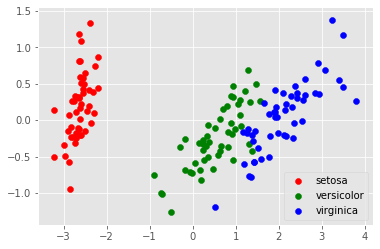

In [51]:
plot_iris(projections3, target=target3, target_names=target_names3)

In [52]:
corr_3_1, corr_3_2 = [], []
for i in range(4):
    corr_3_1.append(np.corrcoef(projections3[:,0] - projections3[:,0].mean(), data3[:,i] - data3[:,i].mean())[0,1])
    corr_3_2.append(np.corrcoef(projections3[:,1] - projections3[:,1].mean(), data3[:,i] - data3[:,i].mean())[0,1])

In [53]:
corr_3_1

[0.8974017619582985,
 -0.3987484724557003,
 0.9978739422413109,
 0.9665475167033069]

In [54]:
corr_3_2

[0.39060441288849346,
 0.8252287092319975,
 -0.048380599689890766,
 -0.04878160292939421]

1 3 4 2

## Интерпретация главных компонент с использованием данных

Рассмотрим теперь величину, которую можно проинтерпретировать, как квадрат косинуса угла между объектом выборки и главной компонентой:

$$ cos^2_{ik} = \frac{f_{ik}^2}{\sum_{\ell=1}^d f_{i\ell}^2} $$

где
- i -- номер объекта
- k -- номер главной компоненты
- $f_{ik}$ -- модуль центрированной проекции объекта на компоненту

Очевидно, что

$$ \sum_{k=1}^d cos^2_{ik} = 1 $$

Это значит, что для каждого объекта мы в виде данной величины получили веса, пропорциональные вкладу, которую вносит данный объект в дисперсию каждой компоненты. Чем больше вклад, тем более значим объект для описания конкретной главной компоненты.

## Задание 4. Анализ главных компонент при помощи вкладов в их дисперсию отдельных объектов

1. Загрузите датасет лиц Olivetti Faces и обучите на нём модель RandomizedPCA (используется при большом количестве признаков и работает быстрее, чем обычный PCA). Получите проекции признаков на 10 первых главных компонент.
2. Посчитайте для каждого объекта его относительный вклад в дисперсию каждой из 10 компонент, используя формулу из предыдущего раздела (d = 10).
3. Для каждой компоненты найдите и визуализируйте лицо, которое вносит наибольший относительный вклад в неё. Для визуализации используйте функцию

        plt.imshow(image.reshape(image_shape))
        
4. Передайте в форму список номеров лиц с наибольшим относительным вкладом в дисперсию каждой из компонент, список начинается с 0.

In [55]:
from sklearn.datasets import fetch_olivetti_faces
from sklearn.decomposition import PCA


data4 = fetch_olivetti_faces(shuffle=True, random_state=0).data
image_shape = (64, 64)

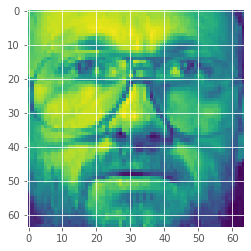

In [56]:
plt.imshow(data4[0].reshape(image_shape))

In [57]:
model4 = PCA(n_components=10, svd_solver='randomized')
model4.fit(data4)

PCA(copy=True, iterated_power='auto', n_components=10, random_state=None,
    svd_solver='randomized', tol=0.0, whiten=False)

In [58]:
projections4 = model4.transform(data4)

In [63]:
projections4[0]

array([ 0.815795  , -4.144037  ,  2.4832604 , -0.90308875,  0.83136237,
        0.886227  , -0.8663992 , -2.1643088 ,  0.25090596, -0.6027778 ],
      dtype=float32)

In [59]:
cosx = []
for i in range(400):
    cosx.append([(projections4[i, k])**2/sum((projections4[i])**2) for k in range(10)])

In [60]:
cosx

[[0.020695073504180594,
  0.5340133209895862,
  0.19175619956390028,
  0.025360963739676202,
  0.02149243455464106,
  0.02442276643119424,
  0.023342157980729333,
  0.14566101613749607,
  0.001957613035335101,
  0.01129846275391397],
 [0.24986631904807663,
  0.029816707180350864,
  0.4925054709212082,
  0.04038177147160451,
  0.15905584903829845,
  0.00011715572592590756,
  0.0023015152805529702,
  0.0027767011113479143,
  0.01919970169274831,
  0.003978820018192924],
 [0.3876422764389041,
  0.005101249312027517,
  0.01277846636624602,
  0.08488463873310327,
  0.3153821108884839,
  0.042763201597567586,
  0.00813092827823363,
  0.026339755168400765,
  0.07405982074348907,
  0.042917563399077464],
 [0.24867625198975357,
  0.15343906630948334,
  0.0010502388046929746,
  0.040931113797974795,
  0.08736420307156521,
  0.010109673083527313,
  0.22245197376425183,
  0.1544561353426307,
  0.08023863603445172,
  0.0012826984470896434],
 [0.22461263579005217,
  0.10348405138132648,
  0.25872391

In [65]:
maximums = []
for k in range(10):
    maximums.append(np.argmax(np.array(cosx)[:,k]))

In [66]:
maximums

[197, 18, 66, 319, 363, 131, 142, 382, 353, 140]

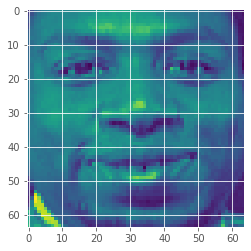

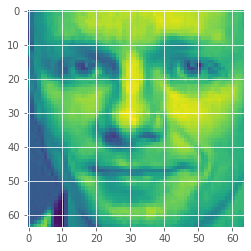

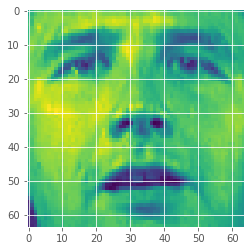

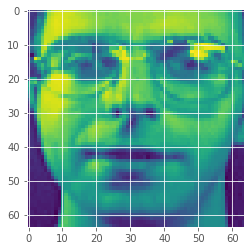

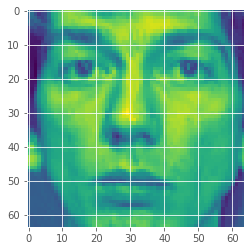

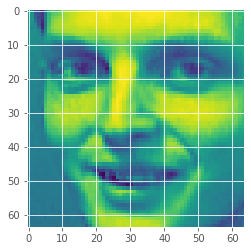

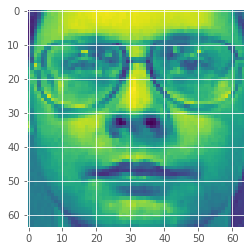

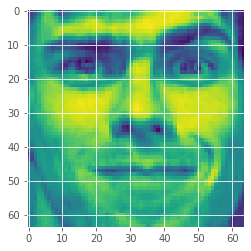

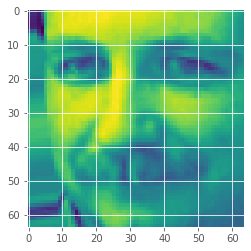

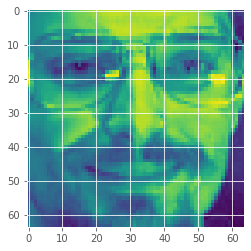

In [67]:
for k in maximums:
    plt.imshow(data4[k].reshape(image_shape))
    plt.show()

## Анализ основных недостатков метода главных компонент

Рассмотренные выше задачи являются, безусловно, модельными, потому что данные для них были сгенерированы в соответствии с предположениями метода главных компонент. На практике эти предположения, естественно, выполняются далеко не всегда. Рассмотрим типичные ошибки PCA, которые следует иметь в виду перед тем, как его применять.

### Направления с максимальной дисперсией в данных неортогональны

Рассмотрим случай выборки, которая сгенерирована из двух вытянутых нормальных распределений:

C:\Users\Vlad\anaconda3\lib\site-packages\ipykernel_launcher.py:7: RuntimeWarning: covariance is not positive-semidefinite.
  import sys


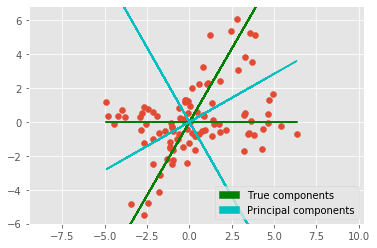

In [68]:
C1 = np.array([[10,0],[0,0.5]])
phi = np.pi/3
C2 = np.dot(C1, np.array([[np.cos(phi), np.sin(phi)],
                          [-np.sin(phi),np.cos(phi)]]))

data = np.vstack([np.random.multivariate_normal(mu, C1, size=50),
                  np.random.multivariate_normal(mu, C2, size=50)])
plt.scatter(data[:,0], data[:,1])
# построим истинные интересующие нас компоненты
plt.plot(data[:,0], np.zeros(data[:,0].size), color="g")
plt.plot(data[:,0], 3**0.5*data[:,0], color="g")
# обучим модель pca и построим главные компоненты
model = PCA(n_components=2)
model.fit(data)
plot_principal_components(data, model, scatter=False, legend=False)
c_patch = mpatches.Patch(color='c', label='Principal components')
plt.legend(handles=[g_patch, c_patch])
plt.draw()

В чём проблема, почему pca здесь работает плохо? Ответ прост: интересующие нас компоненты в данных коррелированны между собой (или неортогональны, в зависимости от того, какой терминологией пользоваться). Для поиска подобных преобразований требуются более сложные методы, которые уже выходят за рамки метода главных компонент.

Для интересующихся: то, что можно применить непосредственно к выходу метода главных компонент, для получения подобных неортогональных преобразований, называется методами ротации. Почитать о них можно в связи с другим методом уменьшения размерности, который называется Factor Analysis (FA), но ничего не мешает их применять и к главным компонентам.

### Интересное направление в данных не совпадает с направлением максимальной дисперсии

Рассмотрим пример, когда дисперсии не отражают интересующих нас направлений в данных:

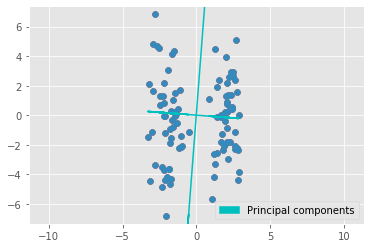

In [69]:
C = np.array([[0.5,0],[0,10]])
mu1 = np.array([-2,0])
mu2 = np.array([2,0])

data = np.vstack([np.random.multivariate_normal(mu1, C, size=50),
                  np.random.multivariate_normal(mu2, C, size=50)])
plt.scatter(data[:,0], data[:,1])
# обучим модель pca и построим главные компоненты
model = PCA(n_components=2)
model.fit(data)
plot_principal_components(data, model)
plt.draw()

Очевидно, что в данном случае метод главных компонент будет считать вертикальную компоненту более значимой для описания набора данных, чем горизонтальную. 

Но, например, в случае, когда данные из левого и правого кластера относятся к разным классам, для их линейной разделимости вертикальная компонента является шумовой. Несмотря на это, её метод главных компонент никогда шумовой не признает, и есть вероятность, что отбор признаков с его помощью выкинет из ваших данных значимые для решаемой вами задачи компоненты просто потому, что вдоль них значения имеют низкую дисперсию.

Справляться с такими ситуациями могут некоторые другие методы уменьшения размерности данных, например, метод независимых компонент (Independent Component Analysis, ICA).